# Generate reproducible random data for simulation experiment

**Gregory Way 2018**

*scripts/simulation_experiment_data.ipynb*


The experiment will test how various algorithms are able to extract signals through compressing input data.

The algorithms include: 

1. PCA
2. ICA
3. NMF
4. ADAGE
5. Tybalt
6. Conditional VAE
7. Adversarial Autoencoder

The data matrix will consist of 12,000 samples and various types of features:

1. Two group specific features - Three groups of data represented by two dimensions
2. One boolean feature - a feature randomly present in 50% of samples
3. Two continuous function mappings - Nonlinear mapping of random domain based on function transform
4. Two cell-type specific features added in different proportions
5. The above features with variable number of random noise injection - [0, 5, 20, 100]

**This script will generate four datasets that will be evaluated downstream**

In [1]:
library(tibble)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# Load custom simulation functions
source(file.path("util", "simulate_expression.R"))

In [3]:
# Store seeds for each dataset
seeds <- c(1, 2, 3, 4)

In [4]:
# Set Variables
num_samples <- 12000

group_mean <- as.matrix(cbind(c(1, 5, 3), c(4, 0, 2)))
group_sd <- as.matrix(cbind(c(1, 1, 1), c(1, 1, 1)))

num_boolean_features <- 1

cell_mean <- as.matrix(cbind(c(1, 4), c(5, 2)))
cell_sd <- as.matrix(cbind(c(1, 1), c(1, 1)))

x_squared <- function(x) { x ** 2 + 1}
two_x_third <- function(x) {2 * x ** 3 + 1}
func_list <- list(x_squared, two_x_third)

random_noise <- c(0, 5, 20, 100)

In [5]:
# Simulate data and save to folder
output_folder <- file.path("..", "data", "simulation")
noise_idx <- 1
for (num_noise_features in random_noise) {
  sim_df <- getSimulatedExpression(n = num_samples,
                                   mean_df = group_mean,
                                   sd_df = group_sd,
                                   b = num_boolean_features,
                                   func_list = func_list,
                                   seed = seeds[noise_idx],
                                   cell_type_mean_df = cell_mean,
                                   cell_type_sd_df = cell_sd,
                                   r = num_noise_features,
                                   concat = TRUE)

  sim_data_file <- paste0("sim_data_", num_noise_features, "_noise.tsv")
  sim_data_file <- file.path(output_folder, sim_data_file)
  write.table(sim_df, sim_data_file, sep = "\t")

  noise_idx <- noise_idx + 1
}

## Visualize Simulated Data

In [6]:
# Example with 100 noise features
head(sim_df)

group_1,group_2,random_1,random_2,random_3,random_4,random_5,random_6,random_7,random_8,⋯,random_100,continuous_1,continuous_2,presence_1,cell_type_1,cell_type_2,groups,cell_type_prop,continuous_domain_1,continuous_domain_2
0.3547782,0.6296049,0.3413966,0.63510998,0.3518972,0.58752413,0.8652956,0.9467623,0.7236759,0.8179838,⋯,0.42030770,0.03499705,0.6577723,0.7460035,0.5347534,0.4443229,a,0.3324922,-0.1870650,0.68076050
0.6526326,0.2260182,0.6351497,0.75934128,0.6688091,0.87148691,0.4106521,0.1732314,0.7390345,0.2658861,⋯,0.04327081,0.04118467,0.1873564,0.5961492,0.5612793,0.3997267,b,0.2255394,-0.2029292,-0.85496603
0.6005787,0.5579470,0.7508442,0.23742561,0.4244148,0.17207625,0.9199896,0.9882325,0.8018468,0.8067360,⋯,0.27677172,0.46653906,0.5113883,0.6744677,0.4360522,0.5908010,c,0.4461367,-0.6830001,0.28373426
0.3896324,0.6094544,0.3934666,0.61298147,0.9576038,0.99403009,0.9303663,0.2470703,0.4231658,0.1994782,⋯,0.55859577,0.15234634,0.4999618,0.0000000,0.4584673,0.6043418,a,0.8088187,0.3902948,-0.01126805
0.8528206,0.3756762,0.5869715,0.15246109,0.4356075,0.01395064,0.3768978,0.3415740,0.7343257,0.1334994,⋯,0.07184918,0.52912461,0.4999531,0.0000000,0.4021169,0.6798294,b,0.6398024,-0.7273706,-0.02664167
0.5820251,0.5441209,0.4301287,0.06998604,0.1298669,0.80796893,0.4766815,0.9404474,0.7283759,0.6373319,⋯,0.58387720,0.13702314,0.8790328,0.0000000,0.5470881,0.2537834,c,0.1168379,0.3701466,0.91170904


### What do the groups look like?

The evaluation will test if any compressed features extract group specific importance scores. The weights assigned to each compressed feature should correspond to group features and this plot should be able to be reproduced with compressed features as large sources of variation in the input data

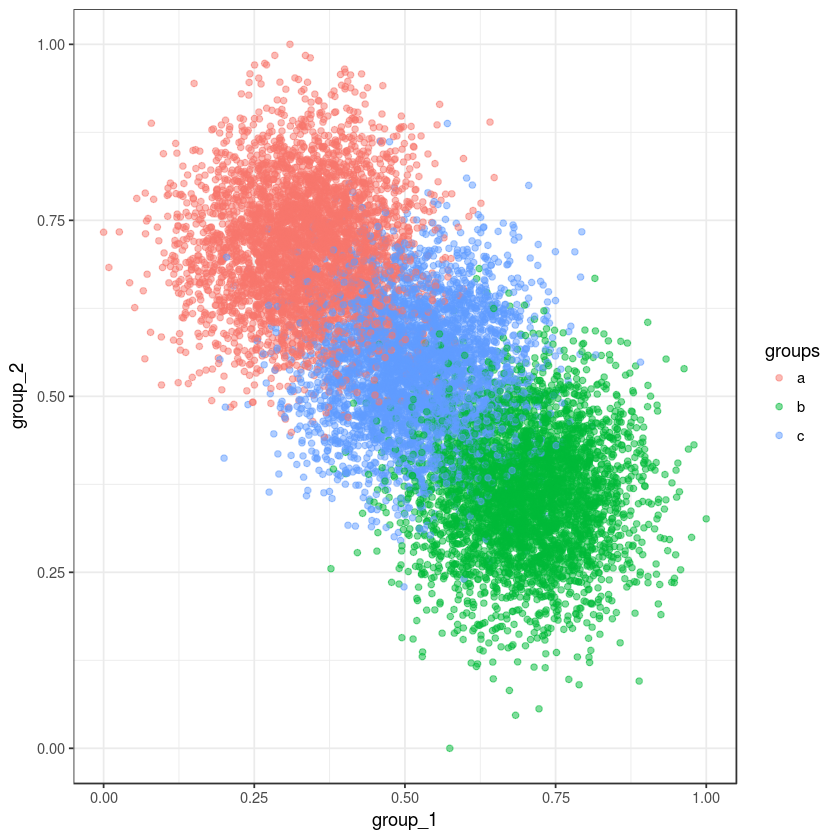

In [7]:
ggplot(sim_df, aes(x=group_1, y=group_2)) + geom_point(aes(color=groups), alpha=0.5) +
  theme_bw()

### Continuous, nonlinear features

These features are present in the input data and form a nonlinear transformation. Since the domains will not be included in training, the evaluation will be a correlation analysis between a compressed feature and the continuous domain held out from training.

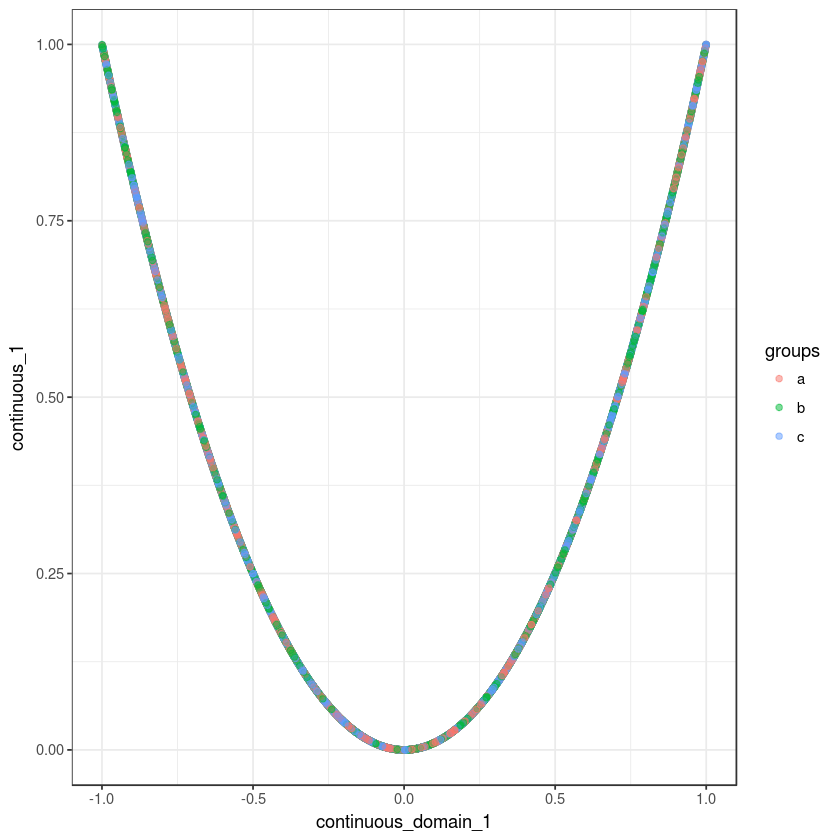

In [8]:
ggplot(sim_df, aes(x=continuous_domain_1, y=continuous_1)) +
  geom_point(aes(color=groups), alpha=0.5) + theme_bw()

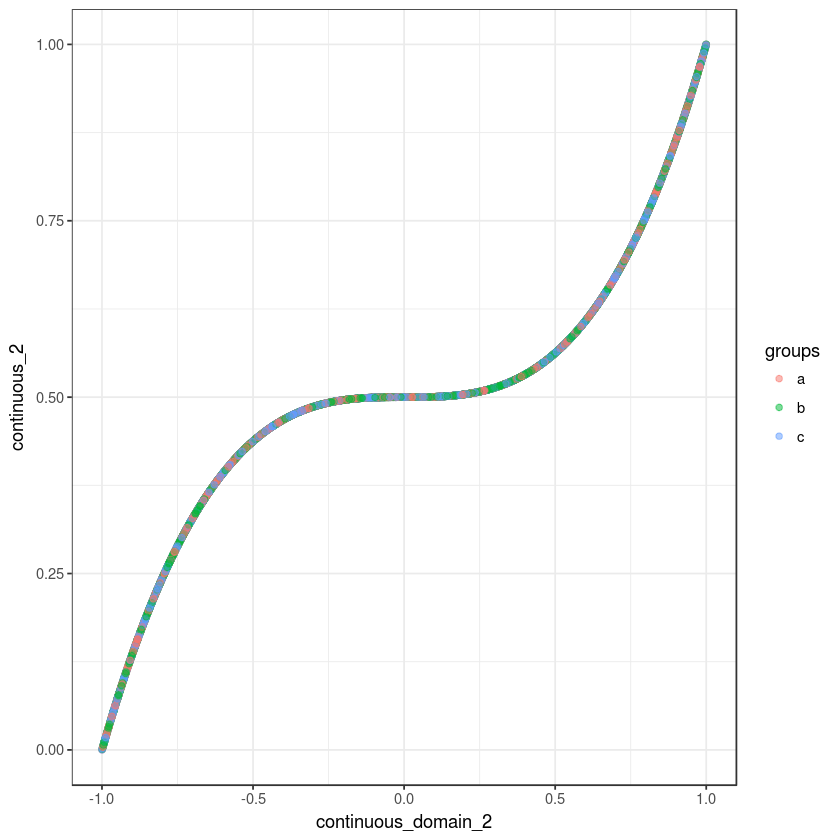

In [9]:
ggplot(sim_df, aes(x=continuous_domain_2, y=continuous_2)) +
  geom_point(aes(color=groups), alpha=0.5) + theme_bw()

### Randomly present (boolean) feature

This feature is randomly present or absent in the dataset. This feature will enable a latent space arithmetic (LSA) based evaluation. For example, in the latent space, `group1 with feature` - `group 1 without feature` + `group 2 without feature` = `group 2 with feature`? We will test the distance in reconstructed feature space of real simulated data against predictions by LSA across algorithms.

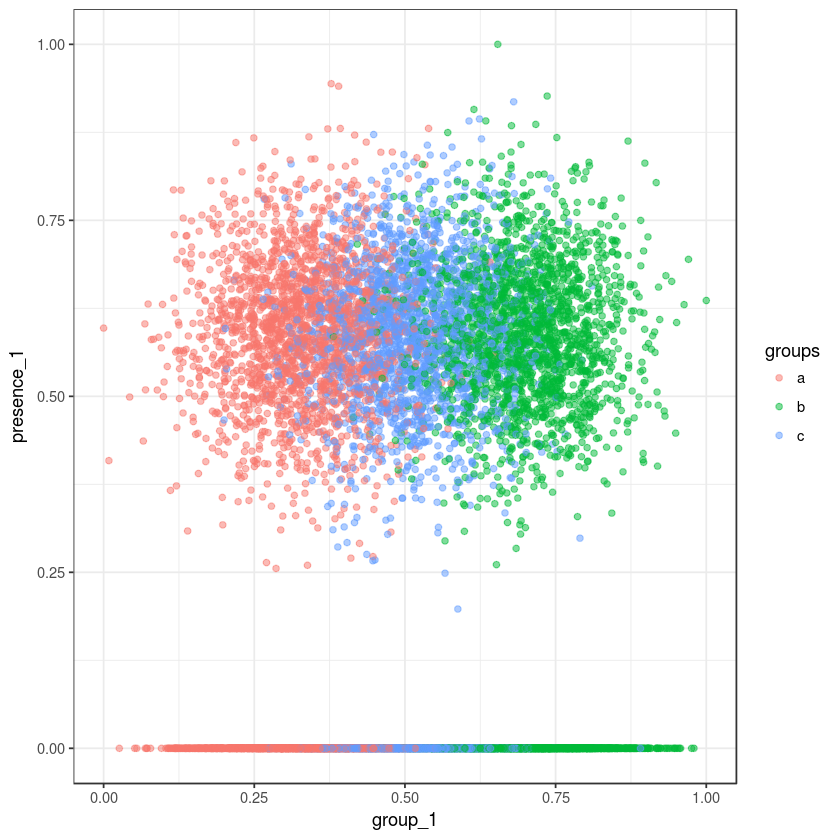

In [10]:
ggplot(sim_df, aes(x=group_1, y=presence_1)) + geom_point(aes(color=groups), alpha=0.5) +
  theme_bw()

### Cell-type specific features

These features are added together at random proportions. The ground truth proportion (size of points below) is not provided to the compression algorithms. We will test if compression features correlate with the ground truth proportion across algorithms. 

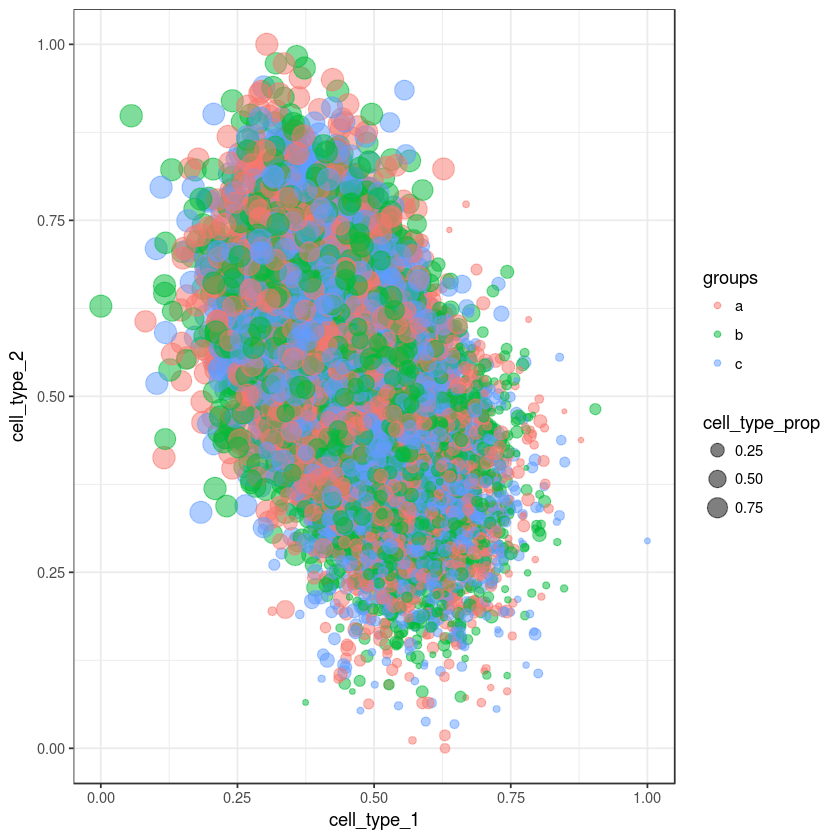

In [11]:
ggplot(sim_df, aes(x=cell_type_1, y=cell_type_2)) +
  geom_point(aes(color=groups, size=cell_type_prop), alpha=0.5) +
  theme_bw()

### Random Features

We will evaluate the algorithms in identifying the aformentioned sources of variation in the data given different levels of noise injection. The four scenarios are 0 noise features, 5 noise features, 20 noise features, and 100 noise features. All noise is randomly sampled data from a uniform distribution.

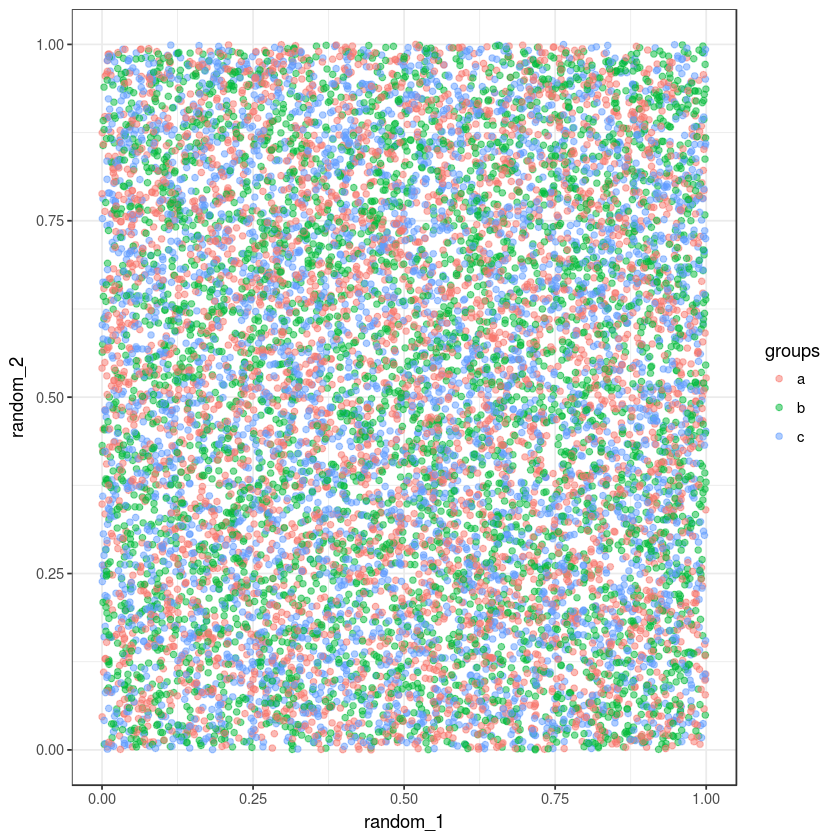

In [12]:
ggplot(sim_df, aes(x=random_1, y=random_2)) + geom_point(aes(color=groups), alpha=0.5) +
  theme_bw()